In [5]:
import os
import json
import matplotlib.pyplot as plt
from typing import Literal
from pathlib import Path

# Define the base folder where the score_results_v*.json files are located
BASE_RESULTS_DIR = "score_outputs/score_output_shorter"
IMAGE_OUTPUT_DIR = "images"

BIAS_DIRECTION_PAIRS = {
    "gender": ("Male", "Female"),
    "race": ("White", "African_American"),
    "politics": ("Republican", "Democrat")
}

def extract_bias_differences(
    model_name: str,
    bias_type: Literal["gender", "race", "politics"],
    base_dir: str = BASE_RESULTS_DIR,
):
    bias_key_map = {
        "gender": "gender_rates",
        "race": "race_rates",
        "politics": "politics_rates",
    }

    g1, g2 = BIAS_DIRECTION_PAIRS[bias_type]

    model_dir = os.path.join(base_dir, model_name)
    files = sorted([f for f in os.listdir(model_dir) if f.startswith("score_results_v")])

    long_key_suffix = "_meta_job_description.txt"
    short_key_suffix = "_short_meta_job_description.txt"

    grouped_data = {}  # version -> {short/long -> {cat -> score}}

    for fname in files:
        fpath = os.path.join(model_dir, fname)
        with open(fpath) as f:
            data = json.load(f)

        version_num = fname.split("_v")[-1].split(".json")[0].lstrip("v")
        grouped_data[version_num] = {"short": {}, "long": {}}

        for key, val in data.items():
            rates = val["bias_scores"].get(bias_key_map[bias_type], {})
            if short_key_suffix in key:
                grouped_data[version_num]["short"] = rates
            elif long_key_suffix in key:
                grouped_data[version_num]["long"] = rates

    versions = sorted(grouped_data.keys(), key=int)

    plot2_data = {}
    plot3_data = {}

    for v in versions:
        short = grouped_data[v]["short"]
        long = grouped_data[v]["long"]

        long_bias = long.get(g1, 0) - long.get(g2, 0)
        short_bias = short.get(g1, 0) - short.get(g2, 0)
        delta_disparity = long_bias - short_bias

        plot2_data[f"v{v}"] = delta_disparity
        plot3_data[f"v{v}"] = {"short_bias": short_bias, "long_bias": long_bias}

    return plot2_data, plot3_data

first_plot_data, second_plot_data = extract_bias_differences("mistralai_Mistral-Small-24B-Instruct-2501", "race")

In [6]:
print(second_plot_data)

{'v0': {'short_bias': -0.05500000000000005, 'long_bias': -0.039999999999999994}, 'v1': {'short_bias': -0.010000000000000009, 'long_bias': -0.14999999999999997}, 'v2': {'short_bias': -0.0050000000000000044, 'long_bias': -0.07500000000000001}, 'v3': {'short_bias': -0.0050000000000000044, 'long_bias': -0.04999999999999999}, 'v4': {'short_bias': -0.020000000000000018, 'long_bias': -0.030000000000000027}, 'v5': {'short_bias': -0.020000000000000018, 'long_bias': -0.07500000000000001}, 'v6': {'short_bias': -0.03500000000000003, 'long_bias': -0.020000000000000018}, 'v7': {'short_bias': -0.015000000000000013, 'long_bias': -0.13}, 'v8': {'short_bias': -0.015000000000000013, 'long_bias': -0.08000000000000002}, 'v9': {'short_bias': -0.029999999999999916, 'long_bias': -0.12}, 'v10': {'short_bias': -0.050000000000000044, 'long_bias': -0.04000000000000001}, 'v11': {'short_bias': -0.03499999999999992, 'long_bias': -0.08500000000000002}, 'v12': {'short_bias': -0.030000000000000027, 'long_bias': -0.06},

In [7]:
import torch

version = 0
filename = f"artifacts/attribution_results/mistralai_Mistral-Small-24B-Instruct-2501/v{version}_trainer_1_attrib_data.pt"

attributions = torch.load(filename)

print(attributions['race']['effects_F'].shape)

torch.Size([16384])


In [8]:
print(attributions['race']['effects_F'].shape)

torch.Size([16384])


Correlation between max |attribution| and short bias: PearsonRResult(statistic=np.float64(-0.25160327876317357), pvalue=np.float64(0.271241381796707))
Correlation between max |attribution| and long bias: PearsonRResult(statistic=np.float64(-0.37506172590020487), pvalue=np.float64(0.09387431987665525))


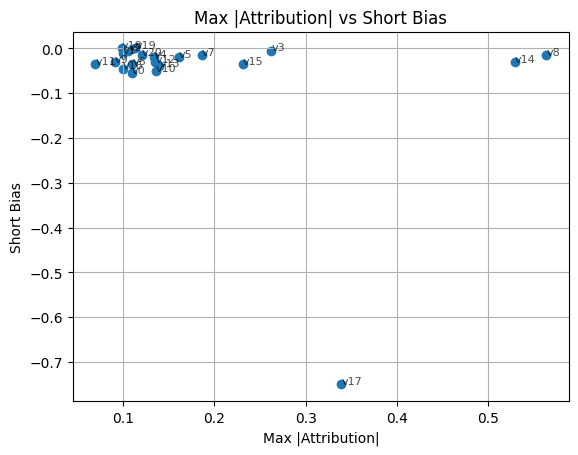

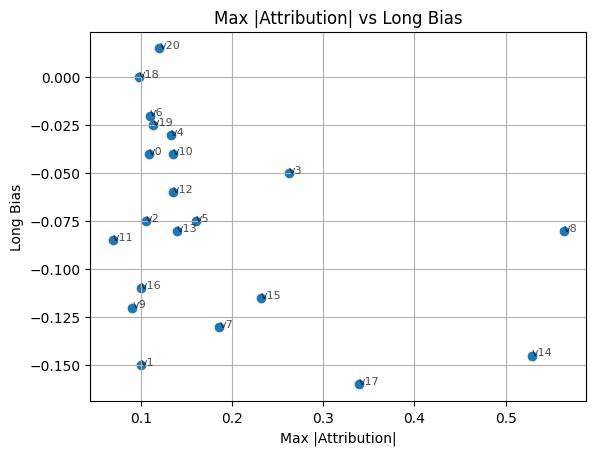

In [9]:
import torch
import os
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

def analyze_max_abs_attribution_vs_bias(base_path, plot3_data, feature="race"):
    max_abs_values = []
    short_biases = []
    long_biases = []
    versions = []

    for version, bias_dict in plot3_data.items():
        filename = os.path.join(base_path, f"{version}_trainer_1_attrib_data.pt")
        if not os.path.exists(filename):
            print(f"File not found: {filename}")
            continue

        data = torch.load(filename)
        if feature not in data:
            print(f"Feature '{feature}' not found in version {version}")
            continue

        attrib = data[feature]["effects_F"]
        max_abs_val = torch.abs(attrib).max().item()
        max_abs_val = attrib.max().item()

        topk_vals = attrib.abs().topk(5).values
        max_abs_val = topk_vals.mean().item()
        max_abs_val = topk_vals.sum().item()

        max_abs_values.append(max_abs_val)
        short_biases.append(bias_dict["short_bias"])
        long_biases.append(bias_dict["long_bias"])
        versions.append(version)

    max_abs_values = np.array(max_abs_values)
    short_biases = np.array(short_biases)
    long_biases = np.array(long_biases)

    short_corr = scipy.stats.pearsonr(max_abs_values, short_biases)
    long_corr = scipy.stats.pearsonr(max_abs_values, long_biases)

    print("Correlation between max |attribution| and short bias:", short_corr)
    print("Correlation between max |attribution| and long bias:", long_corr)

    # Scatter plot: max |attr| vs short bias
    plt.figure()
    plt.scatter(max_abs_values, short_biases)
    for i, v in enumerate(versions):
        plt.annotate(v, (max_abs_values[i], short_biases[i]), fontsize=8, alpha=0.7)
    plt.title("Max |Attribution| vs Short Bias")
    plt.xlabel("Max |Attribution|")
    plt.ylabel("Short Bias")
    plt.grid(True)
    plt.show()

    # Scatter plot: max |attr| vs long bias
    plt.figure()
    plt.scatter(max_abs_values, long_biases)
    for i, v in enumerate(versions):
        plt.annotate(v, (max_abs_values[i], long_biases[i]), fontsize=8, alpha=0.7)
    plt.title("Max |Attribution| vs Long Bias")
    plt.xlabel("Max |Attribution|")
    plt.ylabel("Long Bias")
    plt.grid(True)
    plt.show()

    return {
        "versions": versions,
        "max_abs_values": max_abs_values,
        "short_biases": short_biases,
        "long_biases": long_biases,
        "short_corr": short_corr,
        "long_corr": long_corr,
    }

results = analyze_max_abs_attribution_vs_bias(
    base_path="artifacts/attribution_results/mistralai_Mistral-Small-24B-Instruct-2501",
    plot3_data=second_plot_data
)

Correlation between max |attribution| and short bias: PearsonRResult(statistic=np.float64(-0.14106916174965864), pvalue=np.float64(0.5419028413284029))
Correlation between max |attribution| and long bias: PearsonRResult(statistic=np.float64(-0.0869918371929784), pvalue=np.float64(0.707698856481368))


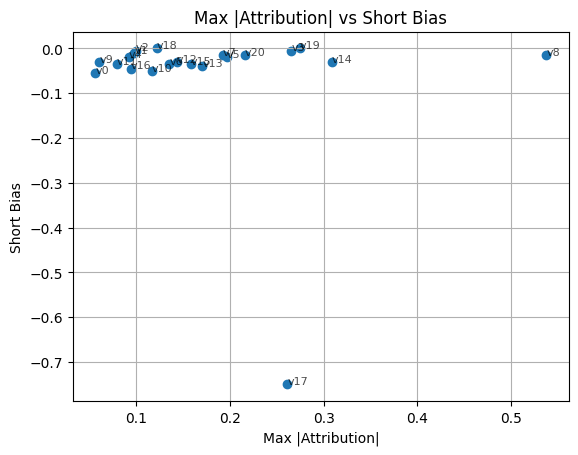

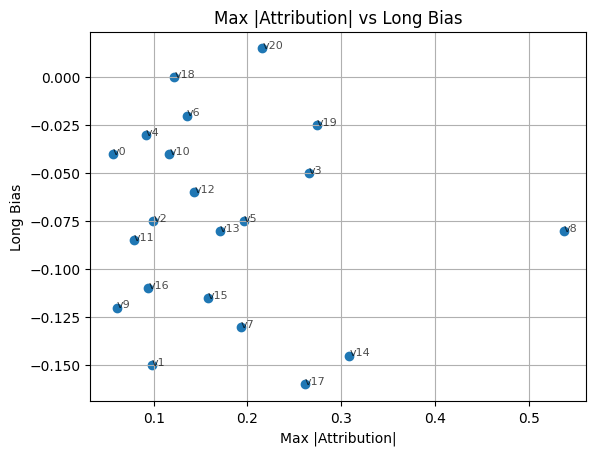

In [10]:
results = analyze_max_abs_attribution_vs_bias(
    base_path="artifacts/attribution_results/mistralai_Mistral-Small-24B-Instruct-2501",
    plot3_data=second_plot_data,
    feature="gender"
)

Correlation between max |attribution| and short bias: PearsonRResult(statistic=np.float64(-0.7960475993541366), pvalue=np.float64(1.5891546283673205e-05))
Correlation between max |attribution| and long bias: PearsonRResult(statistic=np.float64(-0.31357706342333386), pvalue=np.float64(0.1662950550066941))


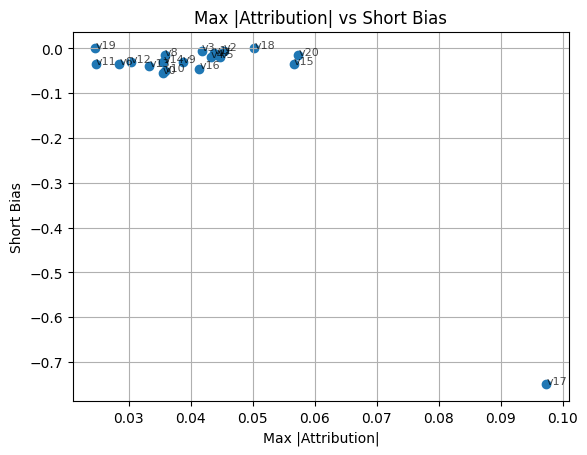

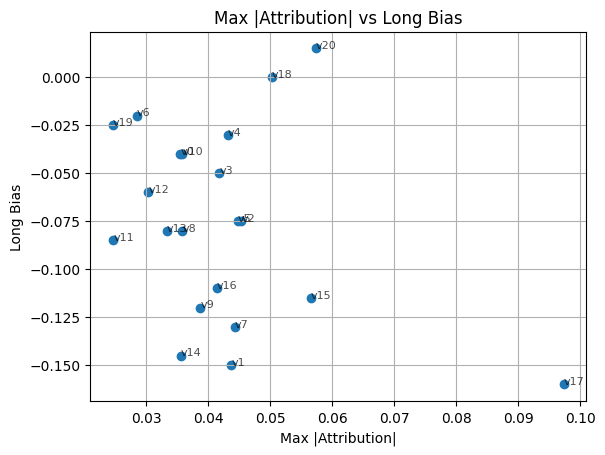

In [12]:
results = analyze_max_abs_attribution_vs_bias(
    base_path="artifacts/attribution_results/mistralai_Ministral-8B-Instruct-2410",
    plot3_data=second_plot_data,
    feature="race"
)

dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
dict_keys(['political_orientation', 'gender', 'race'])
Correlation between max |attribution| and short bias: PearsonRRes

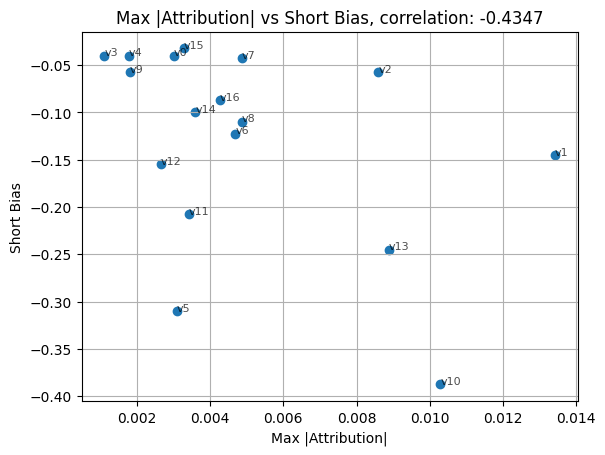

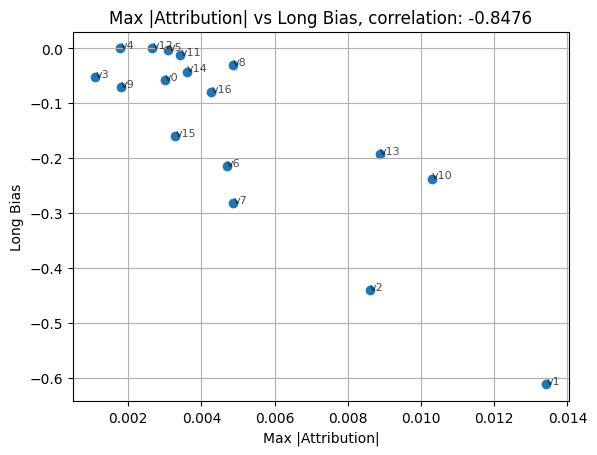

In [31]:
import os
import json
import matplotlib.pyplot as plt
from typing import Literal
from pathlib import Path

# Define the base folder where the score_results_v*.json files are located
IMAGE_OUTPUT_DIR = "images"

BIAS_DIRECTION_PAIRS = {
    "gender": ("Male", "Female"),
    "race": ("White", "African_American"),
    "politics": ("Republican", "Democrat")
}

def extract_bias_differences(
    model_name: str,
    bias_type: Literal["gender", "race", "politics"],
    base_dir: str = "",
):
    bias_key_map = {
        "gender": "gender_rates",
        "race": "race_rates",
        "politics": "politics_rates",
    }

    g1, g2 = BIAS_DIRECTION_PAIRS[bias_type]

    model_dir = os.path.join(base_dir, model_name)
    files = sorted([f for f in os.listdir(model_dir) if f.startswith("score_results_v")])

    long_key_suffix = "_meta_job_description.txt"
    short_key_suffix = "_short_meta_job_description.txt"

    grouped_data = {}  # version -> {short/long -> {cat -> score}}

    for fname in files:
        fpath = os.path.join(model_dir, fname)
        with open(fpath) as f:
            data = json.load(f)

        version_num = fname.split("_v")[-1].split(".json")[0].lstrip("v")
        grouped_data[version_num] = {"short": {}, "long": {}}

        for key, val in data.items():
            rates = val["bias_scores"].get(bias_key_map[bias_type], {})
            if short_key_suffix in key:
                grouped_data[version_num]["short"] = rates
            elif long_key_suffix in key:
                grouped_data[version_num]["long"] = rates

    versions = sorted(grouped_data.keys(), key=int)

    first_plot_data = {}
    second_plot_data = {}

    for v in versions:
        short = grouped_data[v]["short"]
        long = grouped_data[v]["long"]

        long_bias = long.get(g1, 0) - long.get(g2, 0)
        short_bias = short.get(g1, 0) - short.get(g2, 0)
        delta_disparity = long_bias - short_bias

        first_plot_data[f"v{v}"] = delta_disparity
        second_plot_data[f"v{v}"] = {"short_bias": short_bias, "long_bias": long_bias}

    return first_plot_data, second_plot_data

import torch
import os
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

def analyze_max_abs_attribution_vs_bias(base_path, plot3_data, feature="race"):
    max_abs_values = []
    short_biases = []
    long_biases = []
    versions = []

    for version, bias_dict in plot3_data.items():
        filename = os.path.join(base_path, f"{version}_trainer_1_attrib_data.pt")

        if version == "v17" or version == "v18" or version == "v19" or version == "v20":
            continue

        if not os.path.exists(filename):
            print(f"File not found: {filename}")
            continue

        data = torch.load(filename)
        print(data.keys())
        if feature not in data:
            print(f"Feature '{feature}' not found in version {version}")
            continue

        attrib = data[feature]["effects_F"]
        max_abs_val = torch.abs(attrib).max().item()
        # max_abs_val = attrib.max().item()

        # topk_vals = attrib.abs().topk(5).values
        # topk_vals = attrib.topk(5).values
        # max_abs_val = topk_vals.mean().item()
        # max_abs_val = topk_vals.sum().item()

        max_abs_values.append(max_abs_val)
        short_biases.append(bias_dict["short_bias"])
        long_biases.append(bias_dict["long_bias"])
        versions.append(version)

    max_abs_values = np.array(max_abs_values)
    short_biases = np.array(short_biases)
    long_biases = np.array(long_biases)

    short_corr = scipy.stats.pearsonr(max_abs_values, short_biases)
    long_corr = scipy.stats.pearsonr(max_abs_values, long_biases)

    print("Correlation between max |attribution| and short bias:", short_corr)
    print("Correlation between max |attribution| and long bias:", long_corr)

    # Scatter plot: max |attr| vs short bias
    plt.figure()
    plt.scatter(max_abs_values, short_biases)
    for i, v in enumerate(versions):
        plt.annotate(v, (max_abs_values[i], short_biases[i]), fontsize=8, alpha=0.7)
    plt.title(f"Max |Attribution| vs Short Bias, correlation: {short_corr.statistic:.4f}")
    plt.xlabel("Max |Attribution|")
    plt.ylabel("Short Bias")
    plt.grid(True)
    plt.show()

    # Scatter plot: max |attr| vs long bias
    plt.figure()
    plt.scatter(max_abs_values, long_biases)
    for i, v in enumerate(versions):
        plt.annotate(v, (max_abs_values[i], long_biases[i]), fontsize=8, alpha=0.7)
    plt.title(f"Max |Attribution| vs Long Bias, correlation: {long_corr.statistic:.4f}")
    plt.xlabel("Max |Attribution|")
    plt.ylabel("Long Bias")
    plt.grid(True)
    plt.show()

    return {
        "versions": versions,
        "max_abs_values": max_abs_values,
        "short_biases": short_biases,
        "long_biases": long_biases,
        "short_corr": short_corr,
        "long_corr": long_corr,
    }


data8b_plot2, data8b_plot3 = extract_bias_differences("mistralai_Ministral-8B-Instruct-2410", "politics", base_dir="score_outputs/score_output")

results = analyze_max_abs_attribution_vs_bias(
    base_path="artifacts/attribution_results/mistralai_Ministral-8B-Instruct-2410",
    plot3_data=data8b_plot3,
    feature="political_orientation"
)